In [1]:
import logging
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import time
import numpy as np
import sys
from models.baseline_snli import encoder
from models.baseline_snli import atten
import argparse
from models.snli_data import snli_data
from models.snli_data import w2v
from torch import autograd
from IPython.display import Markdown, display



import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
mypath = '/Users/danielamaranto/desktop/nlppaper/process/'

In [3]:
def get_errors(dev_lbl_batch,pred):
    error_list=[]
    for i,v in enumerate(dev_lbl_batch.data.numpy()):
        if v != pred[i]:
            error_list.append((i,'T: '+labels_mapping[v]+', O: '+labels_mapping[pred[i]]))
        else:
            error_list.append((i,'T,O:'+labels_mapping[v]))
    return error_list

def update_error_analysis_dict(actual_labels, pred_labels):
    for i in range (len(actual_labels)):
        error_analysis[labels_mapping[actual_labels[i]]][labels_mapping[pred_labels[i]]] += 1

def print_sentence(batch,idx,return_result=True):
    premise = []
    hypothesis = []
    s = dev_batches[batch]
    for pword in s[0][idx]:
        premise.append(idx_to_word[pword])
    for hword in s[1][idx]:
        hypothesis.append(idx_to_word[hword])
    if return_result is True:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)+'\n'+outcomes[batch][1][idx][1]
    else:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)
    
    
def heatmap_alpha1(batch,idx):
    batch_num = batch
    item_in_batch = idx
    hypothesis_words = []
    premise_words = []
    '''
    for i in dev_batches[batch_num][0][item_in_batch]:
        premise_words.append(idx_to_word[i])
    for i in dev_batches[batch_num][1][item_in_batch]:
        hypothesis_words.append(idx_to_word[i])
    df = pd.DataFrame(alphas[batch_num][:,item_in_batch].data.numpy().T, columns=hypothesis_words, index=premise_words)
    sns.heatmap(df, cmap="YlGnBu", annot=True)
    print(print_sentence(batch_num,item_in_batch))
    plt.show()
    '''
    for i in dev_batches[batch_num][0][item_in_batch]:
        premise_words.append(idx_to_word[i])
    for i in dev_batches[batch_num][1][item_in_batch]:
        hypothesis_words.append(idx_to_word[i])
    df = pd.DataFrame(alphas_1[batch_num][item_in_batch].data.numpy(), columns=hypothesis_words, index=premise_words)
    sns.heatmap(df, cmap="YlGnBu", annot=True)
    print(print_sentence(batch_num,item_in_batch))
    plt.show()

    
def heatmap_alpha2(batch,idx):
    batch_num = batch
    item_in_batch = idx
    hypothesis_words = []
    premise_words = []
    for i in dev_batches[batch_num][0][item_in_batch]:
        premise_words.append(idx_to_word[i])
    for i in dev_batches[batch_num][1][item_in_batch]:
        hypothesis_words.append(idx_to_word[i])
    df = pd.DataFrame(alphas_2[batch_num][item_in_batch].data.numpy(), columns=premise_words, index=hypothesis_words)
    sns.heatmap(df,cmap="YlGnBu", annot=True)
    print(print_sentence(batch_num,item_in_batch))

    plt.show()
    
def printmd(string):
    display(Markdown(string))


In [4]:
#Load validation set
w2v_file = mypath+'snli_preprocess/glove.hdf5'

word_vecs = w2v(w2v_file).word_vecs 
dev_file = mypath+'snli_preprocess/val.hdf5'

dev_data = snli_data(dev_file, -1)
dev_batches = dev_data.batches

In [5]:
#Load index to word dictionary
word_dict_path = mypath+'snli_preprocess/word.dict'
idx_to_word = {}
with open(word_dict_path,'r') as inf:
    for line in inf:
        line = line.split()
        idx_to_word[int(line[1])] = line[0]
'''change to 0 indexing'''
idx_to_word = {k-1:v for k,v in idx_to_word.items()}

In [6]:
#Load Model
encode_model_fp = '../ada01_epoch-109_dev-acc-0.839_input-encoder.pt'
atten_model_fp = '../ada01_epoch-109_dev-acc-0.839_inter-atten.pt'
embedding_size = 300
hidden_size = 283
train_lbl_size = 3
para_init = 0.01

#init
input_encoder = encoder(word_vecs.size(0), embedding_size, hidden_size, para_init)
inter_atten = atten(hidden_size, train_lbl_size, para_init,dropout=.2)

#load state (map_location converts model from gpu to cpu)
input_encoder.load_state_dict(torch.load(encode_model_fp, map_location=lambda storage, loc: storage))
inter_atten.load_state_dict(torch.load(atten_model_fp, map_location=lambda storage, loc: storage))

In [7]:
'''
Error Analysis
'''
from collections import defaultdict

labels_mapping = {1:'neutral', 0:'entailment', 2:'contradiction'}
error_analysis = defaultdict(dict)
labels = ['neutral', 'entailment', 'contradiction']

for i in labels_mapping.values():
    for j in labels:
        error_analysis[i][j] = 0
    
def update_error_analysis_dict(actual_lables, pred_labels):
    for i in range (len(actual_lables)):
        error_analysis[labels_mapping[actual_lables[i]]][labels_mapping[pred_labels[i]]] += 1
    

In [8]:
'''
Evaluate model on the dev set.
This may take a few minutes to run.
'''

input_encoder.eval()
inter_atten.eval()
correct = 0.
total = 0.
predicted_lbls = []
alphas_1 = []
alphas_2 = []
outcomes = []

for i in range(len(dev_batches)):
    dev_src_batch, dev_tgt_batch, dev_lbl_batch = dev_batches[i]

    dev_src_batch = Variable(dev_src_batch)
    dev_tgt_batch = Variable(dev_tgt_batch)
    dev_lbl_batch = Variable(dev_lbl_batch)
    dev_src_linear, dev_tgt_linear=input_encoder(
        dev_src_batch, dev_tgt_batch)
    log_prob, alpha1, alpha2 =inter_atten(dev_src_linear, dev_tgt_linear, return_attn=True)

    _, predict=log_prob.data.max(dim=1)
    total += dev_lbl_batch.data.size()[0]
    correct += torch.sum(predict == dev_lbl_batch.data)
    update_error_analysis_dict(dev_lbl_batch.data, predict)
    predicted_lbls.append(predict)
    results = get_errors(dev_lbl_batch,predict)
    alphas_1.append(alpha1)
    alphas_2.append(alpha2)
    outcomes.append((i,results))    

In [9]:
'''
Print error analysis table
'''
error_table = pd.DataFrame(error_analysis)
error_table.fillna(0, inplace=True)
error_table.columns = ['p_' + s for s in error_table.columns] 
error_table


,p_contradiction,p_entailment,p_neutral
contradiction,2735,79,324
entailment,171,2965,349
neutral,372,285,2561


In [10]:
'''Collect Prediciton types into dictionaries
T=Target
O=Output
'''
names = ['T,O:entailment',
         'T,O:neutral',
         'T,O:contradiction',
         'T: entailment, O: contradiction',
         'T: entailment, O: neutral',
         'T: neutral, O: entailment',
         'T: neutral, O: contradiction',
         'T: contradiction, O: entailment',
         'T: contradiction, O: neutral']

correct_idxs = dict.fromkeys(names[:3])
error_idxs = dict.fromkeys(names[3:])

for i in range(len(outcomes[:-1])):
    for j in range(len(outcomes[i][1])):
        if outcomes[i][1][j][1] in names[3:]:
            try:
                error_idxs[outcomes[i][1][j][1]].append((i,j))
            except:
                error_idxs[outcomes[i][1][j][1]]=[(i,j)]
        if outcomes[i][1][j][1] in names[:3]:
            try:
                correct_idxs[outcomes[i][1][j][1]].append((i,j))
            except:
                correct_idxs[outcomes[i][1][j][1]]=[(i,j)]

## correct_idxs and error_idxs are dictionaries.  Each key is a Target/Output set, and each value is a list of all the indexes that fall into that category'''

# **T,O:entailment**

### **alpha1**

Premise: <s> trucks racing
Hypothesis: <s> there are vehicles
T,O:entailment


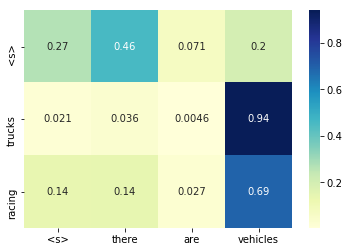

### **alpha2**

Premise: <s> trucks racing
Hypothesis: <s> there are vehicles
T,O:entailment


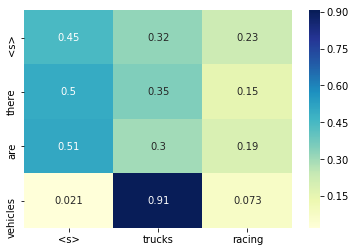

# **T,O:neutral**

### **alpha1**

Premise: <s> javelin competition
Hypothesis: <s> the woman one the javelin competition
T,O:neutral


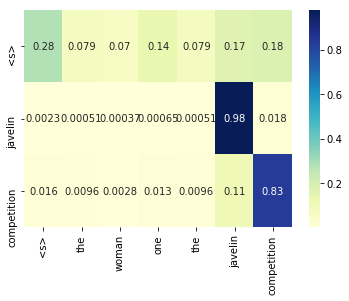

### **alpha2**

Premise: <s> javelin competition
Hypothesis: <s> the woman one the javelin competition
T,O:neutral


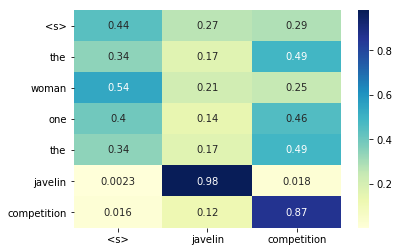

# **T,O:contradiction**

### **alpha1**

Premise: <s> trucks racing
Hypothesis: <s> the trucks are stationary in the parking lot
T,O:contradiction


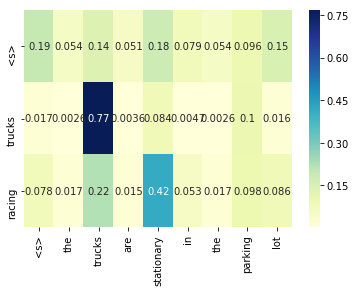

### **alpha2**

Premise: <s> trucks racing
Hypothesis: <s> the trucks are stationary in the parking lot
T,O:contradiction


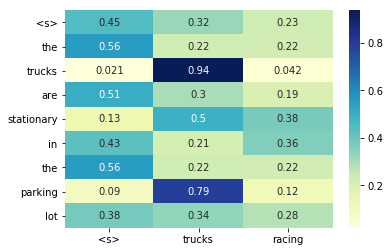

In [11]:
'''Print indexes of different error types'''
for i in correct_idxs.keys():
    printmd('# **'+i+'**')
    for j in range(1):  # For each type of correct prediction, prints the first example  
        entry = correct_idxs[i][j]
        printmd('### **alpha1**')
        heatmap_alpha1(entry[0],entry[1])
        printmd('### **alpha2**')
        heatmap_alpha2(entry[0],entry[1])

# **T: entailment, O: contradiction**

### **alpha1**

Premise: <s> a man snowboards
Hypothesis: <s> a man is standing on a snowboard
T: entailment, O: contradiction


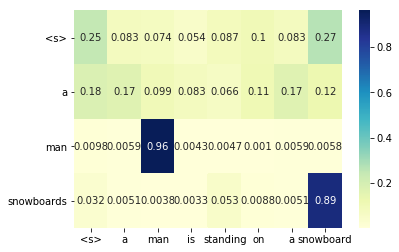

### **alpha2**

Premise: <s> a man snowboards
Hypothesis: <s> a man is standing on a snowboard
T: entailment, O: contradiction


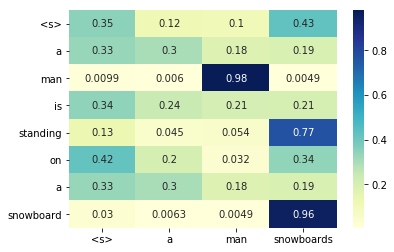

# **T: entailment, O: neutral**

### **alpha1**

Premise: <s> trucks racing
Hypothesis: <s> four trucks are racing against each other in the relay
T: entailment, O: neutral


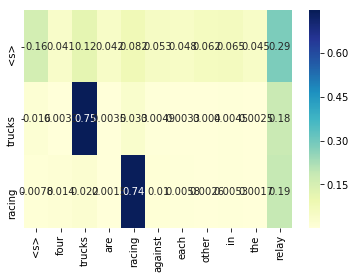

### **alpha2**

Premise: <s> trucks racing
Hypothesis: <s> four trucks are racing against each other in the relay
T: entailment, O: neutral


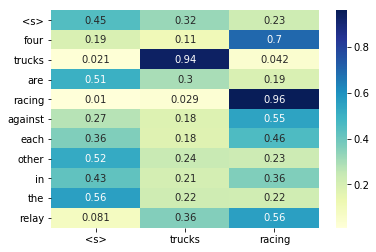

# **T: neutral, O: entailment**

### **alpha1**

Premise: <s> a skateboarder <oov34>
Hypothesis: <s> someone is skateboarding outside
T: neutral, O: entailment


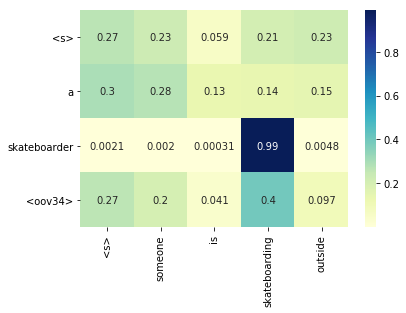

### **alpha2**

Premise: <s> a skateboarder <oov34>
Hypothesis: <s> someone is skateboarding outside
T: neutral, O: entailment


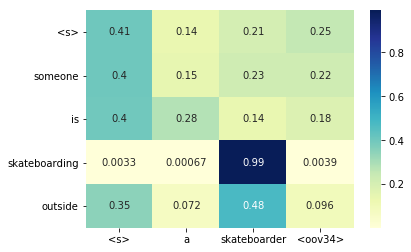

# **T: neutral, O: contradiction**

### **alpha1**

Premise: <s> a motorcycle races
Hypothesis: <s> a bike is racing a cheetah
T: neutral, O: contradiction


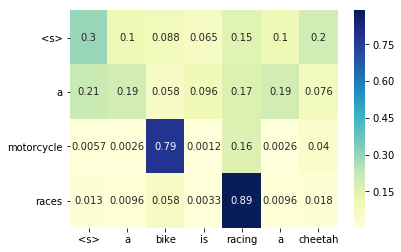

### **alpha2**

Premise: <s> a motorcycle races
Hypothesis: <s> a bike is racing a cheetah
T: neutral, O: contradiction


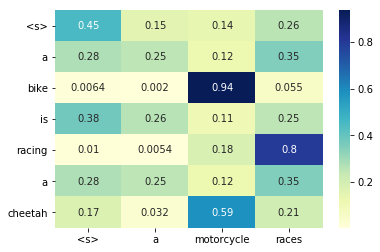

# **T: contradiction, O: entailment**

### **alpha1**

Premise: <s> a motorcycle races
Hypothesis: <s> the bike is not moving
T: contradiction, O: entailment


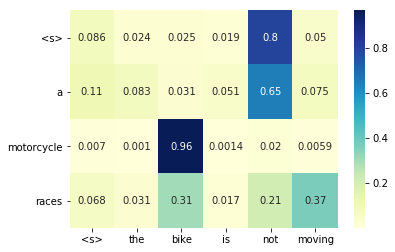

### **alpha2**

Premise: <s> a motorcycle races
Hypothesis: <s> the bike is not moving
T: contradiction, O: entailment


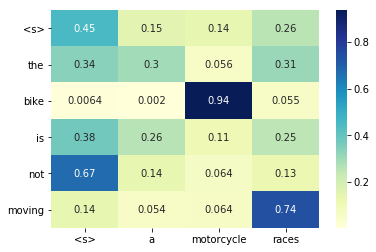

# **T: contradiction, O: neutral**

### **alpha1**

Premise: <s> two men play basketball
Hypothesis: <s> two men are playing dodge ball
T: contradiction, O: neutral


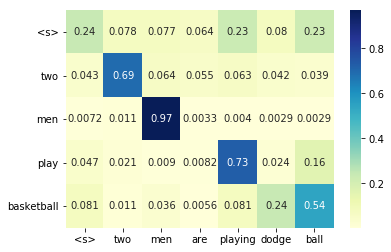

### **alpha2**

Premise: <s> two men play basketball
Hypothesis: <s> two men are playing dodge ball
T: contradiction, O: neutral


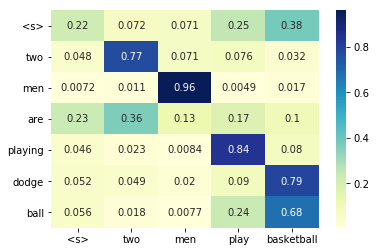

In [12]:
'''Print indexes of different error types'''
for i in error_idxs.keys():
    printmd('# **'+i+'**')
    for j in range(1):  # For each type of incorrect prediction, prints the first example  
        entry = error_idxs[i][j]
        printmd('### **alpha1**')
        heatmap_alpha1(entry[0],entry[1])
        printmd('### **alpha2**')
        heatmap_alpha2(entry[0],entry[1])